In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/diabetes/diabetes.csv")
data.head()
data.shape

(253680, 22)

In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [5]:
target = 'Diabetes_binary'

In [6]:
X = data.drop(columns=[target])
y = data[target]

In [7]:
y_series = pd.Series(y)

# Calculate the class distribution
class_distribution = y_series.value_counts(normalize=True) * 100

print(class_distribution)

0.0    86.258571
1.0    13.741429
Name: Diabetes_binary, dtype: float64


In [8]:
#model_ctgan = CTGANSynthesizer(epochs=20)
#model_ctgan = DPCTGANSynthesizer(verbose=True)
model_ctgan = FPGANSynthesizer(epochs=25,verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data, rate=0.25)

Epoch 1, Loss G: -0.3699,Loss D: -2.1602
Epoch 2, Loss G: -0.3456,Loss D: -0.9278
Epoch 3, Loss G: -0.3349,Loss D: -0.5843
Epoch 4, Loss G: -0.2747,Loss D: -1.0806
Epoch 5, Loss G: -0.2263,Loss D: -1.5900
Epoch 6, Loss G: -0.2260,Loss D: -2.2070
Epoch 7, Loss G: -0.2186,Loss D: -1.6737
Epoch 8, Loss G: -0.1894,Loss D: -1.9141
Epoch 9, Loss G: -0.1980,Loss D: -2.2712
Epoch 10, Loss G: -0.1320,Loss D: -3.0260
Epoch 11, Loss G: -0.1542,Loss D: -3.7952
Epoch 12, Loss G: -0.1500,Loss D: -3.2889
Epoch 13, Loss G: -0.1233,Loss D: -4.0293
Epoch 14, Loss G: -0.1446,Loss D: -3.4830
Epoch 15, Loss G: -0.1664,Loss D: -3.4993
Epoch 16, Loss G: -0.1409,Loss D: -3.3567
Epoch 17, Loss G: -0.1672,Loss D: -3.6551
Epoch 18, Loss G: -0.1712,Loss D: -3.4467
Epoch 19, Loss G: -0.1699,Loss D: -2.9964
Epoch 20, Loss G: -0.1441,Loss D: -3.2203
Epoch 21, Loss G: -0.1709,Loss D: -2.1730
Epoch 22, Loss G: -0.1986,Loss D: -1.6555
Epoch 23, Loss G: -0.1934,Loss D: -1.1808
Epoch 24, Loss G: -0.2191,Loss D: -1.3203
E

([array(0.00304705, dtype=float32),
  array(0.00865701, dtype=float32),
  array(0.0106878, dtype=float32),
  array(0.0124382, dtype=float32),
  array(0.03351963, dtype=float32),
  array(0.04840745, dtype=float32),
  array(0.06918533, dtype=float32),
  array(0.09158646, dtype=float32),
  array(0.13474682, dtype=float32),
  array(0.17717992, dtype=float32),
  array(0.23861177, dtype=float32),
  array(0.2909084, dtype=float32),
  array(0.34299228, dtype=float32),
  array(0.4414551, dtype=float32),
  array(0.5282467, dtype=float32),
  array(0.5995077, dtype=float32),
  array(0.7125824, dtype=float32),
  array(0.7065212, dtype=float32),
  array(0.74290586, dtype=float32),
  array(0.77684, dtype=float32),
  array(0.7274628, dtype=float32),
  array(0.6531789, dtype=float32),
  array(0.56192523, dtype=float32),
  array(0.40384597, dtype=float32),
  array(0.2392456, dtype=float32),
  array(0.06016893, dtype=float32),
  array(-0.14438707, dtype=float32),
  array(-0.2698295, dtype=float32),
  arr

In [9]:
from utils.utils import save_models
save_models(model_ctgan, '025fpgan25', 'diabetes')

In [10]:
from utils.utils import load_models
model_ctgan = load_models('025fpgan25', 'diabetes')

In [11]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [12]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [13]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.1857038]


## Fidelity

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

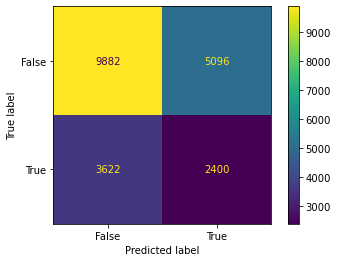

In [15]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [16]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [17]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.7708571428571429
Accuracy of synthetic data:  0.6178095238095238


In [18]:
from utils.fidelity import get_roc_auc

rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.745122195602487
ROC AUC of synthetic data:  0.5296932088916189


## Final plot

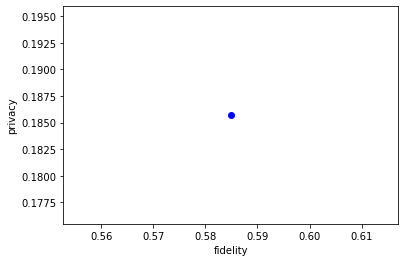

0.5848571428571429 [0.1857038]


In [19]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)